# Initial Modeling with Keras
*for Health Insurance Cross Sell Prediction project*

#### Load Packages

In [83]:
from keras import models
from keras import layers
from keras import metrics
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd

import requests
import io
from pathlib import Path
import os

from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE 

import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix

#### Load Data

In [84]:
# Download train.csv data from GitHub
url = "https://raw.githubusercontent.com/ssears219/Health-Insurance-Cross-Sell-Prediction/main/Data/Kaggle%20Data/train.csv"
file = requests.get(url).content

# Read to pandas df
df = pd.read_csv(io.StringIO(file.decode('utf-8')))
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [85]:
# Identify categorical, continuous, and target columns
cat_cols = ['Gender', 'Driving_License', 'Region_Code', 'Previously_Insured',
               'Vehicle_Age', 'Vehicle_Damage', 'Policy_Sales_Channel']
continuous_cols = ['Age', 'Annual_Premium', 'Vintage']
target = ['Response']

### Prep Data for Fitting the Neural Network

* Explode categorical data
* Scale continous data
* Shuffle data
* Split into train/test sets (train set will be split into train/validation when training the network)
* Over-sample positive target class (those who are interested in vehicle insurance) since it is under-represented

In [86]:
# Convert numerical categorical columns to strings
df['Region_Code'] = df['Region_Code'].astype(str)
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype(str)

# Explode categorical columns
df_cat = pd.get_dummies(df[cat_cols], drop_first=True)
cat_cols = list(df_cat.columns)

# Scale continous data
minmax_scale = MinMaxScaler(feature_range=(0,1))
for col in continuous_cols:
    x = df[col].values.reshape(-1, 1)
    df[col] = minmax_scale.fit_transform(x)

# Combine all final variables
df = pd.concat([df[continuous_cols + target], df_cat], axis=1)

# Shuffle Data
df = df.sample(n=len(df),random_state=10)
df = df.reset_index(drop=True)

# Split into 80% train, 20% test
train = df.sample(frac=0.8, random_state=10)
test = df.drop(train.index)

# Split up train into inputs and outputs
X_train = train.loc[:, train.columns != 'Response'].astype(float)
Y_train = train.loc[:, 'Response']

# Oversampling using SMOTE
smt = SMOTE(random_state=10)
X_train, Y_train = smt.fit_resample(X_train, Y_train)

# Split up test into inputs and outputs
X_test = test.loc[:, test.columns != 'Response'].astype(float)
Y_test = test.loc[:, 'Response']

print('X_train: ', X_train.shape)
print('Y_train: ', Y_train.shape)
print('X_test: ', X_test.shape)
print('Y_test: ', Y_test.shape)

X_train:  (535046, 215)
Y_train:  (535046,)
X_test:  (76222, 215)
Y_test:  (76222,)


### Define, Compile, Fit, and Save Sequential Model

In [87]:
# Define Model
model = models.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape=(215,)))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(32, activation = 'relu'))
model.add(layers.Dense(1, activation='sigmoid'))


# Compile Model
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=[tf.keras.metrics.AUC(name='auc')])

# Fit model
epochs = 1500
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=2048,
                   validation_split=0.2, verbose=0)

# Save model
current_dir = Path(os.getcwd()).absolute()
file_name = 'NN_model_{}epochs.h5'.format(epochs)
f_path = current_dir.joinpath(file_name)
model.save(f_path)

### Plot Training and Validation AUC

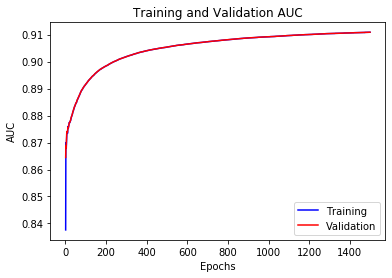

In [90]:
"""
Reference: Deep Learning with Python by François Chollet
           ISBN 9781617294433
"""

history_dict = history.history
epochs = range(1, len(history_dict['auc']) + 1)

auc_values = history_dict['auc']
val_auc_values = history_dict['val_auc']
plt.plot(epochs, auc_values, color='blue', label='Training')
plt.plot(epochs, val_auc_values, color='red', label='Validation')
plt.title('Training and Validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()
plt.show()

### Load Model

In [118]:
epochs=1500
current_dir = Path(os.getcwd()).absolute()
file_name = 'NN_model_{}epochs.h5'.format(epochs)
f_path = current_dir.joinpath(file_name)

model = tf.keras.models.load_model(f_path,compile=False)

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=[tf.keras.metrics.AUC(name='auc')])

### Plot Results for Test Data

AUC:  0.7277058766481167
Accuracy:  0.7827136522263913
Precision:  0.3145559210526316
Recall:  0.6548255938369356


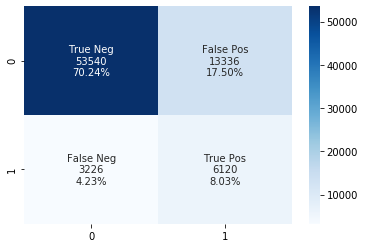

In [121]:
def report(actual, predicted):
    """
    Reference: https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
    """
    AUC = roc_auc_score(actual, predicted)
    accuracy = accuracy_score(actual, predicted)
    precision = precision_score(actual, predicted)
    recall = recall_score(actual, predicted)
    print('AUC: ', AUC)
    print('Accuracy: ', accuracy)
    print('Precision: ', precision)
    print('Recall: ', recall)
    conf_matrix = confusion_matrix(actual, predicted)
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in conf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in conf_matrix.flatten()/np.sum(conf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues')
    return

predictions = model.predict(X_test)
predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0
report(Y_test, predictions)